In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper, provideData
from Utils.transform import cutOut


tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (128,128)
channels = 5

slices = [224,352,224,352]
slices_label = [32,64+32,32,64+32]
cutOutFrame = cutOut(slices)
cutOutFrame_label = cutOut(slices_label)
years = [2015,2016,2017]
PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATION = [cutOutFrame_label]
batch_size = 5

train, test = provideData(dimension=dimension,
                          batch_size=batch_size,
                          channels = channels,
                          timeToPred = 5,
                          year = years,
                          transform=TRANSFORMATION,
                          preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2015 => won't download this year again... please check for consistency
Found Year :  2016 => won't download this year again... please check for consistency
Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 
[DEBUG] Data
[DEBUG] time to predict:  5
[DEBUG] Data
[DEBUG] time to predict:  5


In [3]:
def negative_Binomial_Unet_128x128IN(input_shape,
                           activation_hidden="relu",
                           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up01 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    #up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    #up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64
    
    
    output = Conv2D(2, (1, 1), activation="relu")(up01)  # 1 x 64x64

    shape = tf.shape(output)
    shape = output.shape
    print(shape)
    
    max_count = output[:,:,:,:1]
    prob      = output[:,:,:,1:2]
    max_count = Flatten()(max_count)
    prob      = Flatten()(prob)
    prob      = Dense(16*16)(prob)
    prob      = Dropout(0.1)(prob)
    
    max_count      = Dense(64*64)(max_count)
    #max_count      = Dropout(0.1)(max_count)
    
    prob      = Dense(64*64,activation="sigmoid")(prob)
    max_count = Dense(64*64,activation="sigmoid")(max_count)
    prob      = tf.keras.layers.Reshape((64,64,1))(prob)
    max_count = tf.keras.layers.Reshape((64,64,1))(max_count)
    input_dist= tf.concat([tf.math.softplus(max_count),prob],axis=-1)
    
    #print(max_count)
    
    output_dist = tfp.layers.DistributionLambda(name="DistributionLayer",
        make_distribution_fn=lambda t: tfd.Independent(tfp.distributions.NegativeBinomial(
            total_count=t[..., :1], probs=t[..., 1:2] ),
                                                      reinterpreted_batch_ndims=-1 ))
            #,convert_to_tensor_fn=lambda s: s.sample(64,64,1))

    output = output_dist(input_dist)
    model = Model(inputs=inputs, outputs=output)
    return model

In [4]:
optimizer = Adam( lr = 1e-3 )
trainer = Trainer(negative_Binomial_Unet_128x128IN,
                    lossfunction=NLL,
                    pathToData=(train,test),
                    batch_size = batch_size,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])
layer_name="DistributionLayer"
print(trainer.model.get_layer(layer_name).output)

(None, 64, 64, 2)
[Load file failed]  ./model_data/negative_Binomial_Unet_128x128IN_function/negative_Binomial_Unet_128x128IN_function128x128x5.h5
[Load file failed]  ./model_data/negative_Binomial_Unet_128x128IN_function/negative_Binomial_Unet_128x128IN_function128x128x5history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 10) 460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 10) 0           conv2d[0][0]                     
_______

In [5]:
trainer.fit(400)

Epoch 1/400


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:108: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


5/7 [====================>.........] - ETA: 0s - loss: 0.7372 - mse: 2.8832 - mae: 0.9693
Epoch 00001: val_loss improved from inf to 0.52017, saving model to ./model_data/negative_Binomial_Unet_128x128IN_function/model-001-0.795075-0.520170.h5
7/7 [==============================] - 1s 120ms/step - loss: 0.7951 - mse: 2.7507 - mae: 0.9270 - val_loss: 0.5202 - val_mse: 1.5773 - val_mae: 0.6574
Epoch 2/400
5/7 [====================>.........] - ETA: 0s - loss: 0.6762 - mse: 2.3201 - mae: 0.6332
Epoch 00002: val_loss improved from 0.52017 to 0.41230, saving model to ./model_data/negative_Binomial_Unet_128x128IN_function/model-002-0.633811-0.412299.h5
7/7 [==============================] - 1s 82ms/step - loss: 0.6338 - mse: 2.3784 - mae: 0.6114 - val_loss: 0.4123 - val_mse: 1.5733 - val_mae: 0.4761
Epoch 3/400
5/7 [====================>.........] - ETA: 0s - loss: 0.5930 - mse: 2.0030 - mae: 0.5873
Epoch 00003: val_loss improved from 0.41230 to 0.34864, saving model to ./model_data/negative

Epoch 26/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3237 - mse: 1.5930 - mae: 0.3250
Epoch 00026: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 24ms/step - loss: 0.3320 - mse: 1.6097 - mae: 0.3350 - val_loss: 0.4247 - val_mse: 0.1251 - val_mae: 0.0642
Epoch 27/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3637 - mse: 2.1520 - mae: 0.3964
Epoch 00027: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3693 - mse: 2.0760 - mae: 0.3973 - val_loss: 0.4217 - val_mse: 0.1086 - val_mae: 0.0576
Epoch 28/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3477 - mse: 1.5593 - mae: 0.3543
Epoch 00028: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3516 - mse: 1.5884 - mae: 0.3571 - val_loss: 0.4273 - val_mse: 0.1154 - val_mae: 0.0586
Epoch 29/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3320 - mse: 1.7989

Epoch 53/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3344 - mse: 2.9831 - mae: 0.3881
Epoch 00053: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.3521 - mse: 2.6310 - mae: 0.3915 - val_loss: 0.4282 - val_mse: 0.1136 - val_mae: 0.0540
Epoch 54/400
5/7 [====================>.........] - ETA: 0s - loss: 0.4168 - mse: 2.1869 - mae: 0.4257
Epoch 00054: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3911 - mse: 2.2624 - mae: 0.4103 - val_loss: 0.4564 - val_mse: 0.1023 - val_mae: 0.0552
Epoch 55/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3242 - mse: 2.2012 - mae: 0.3618
Epoch 00055: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.3244 - mse: 1.9292 - mae: 0.3484 - val_loss: 0.5065 - val_mse: 0.1116 - val_mae: 0.0609
Epoch 56/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2888 - mse: 1.2438

Epoch 80/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3542 - mse: 2.3446 - mae: 0.3854
Epoch 00080: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 24ms/step - loss: 0.3101 - mse: 1.9943 - mae: 0.3361 - val_loss: 0.4852 - val_mse: 0.1433 - val_mae: 0.0580
Epoch 81/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3130 - mse: 1.5513 - mae: 0.3188
Epoch 00081: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.3440 - mse: 2.2026 - mae: 0.3673 - val_loss: 0.4885 - val_mse: 0.2694 - val_mae: 0.0539
Epoch 82/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3528 - mse: 2.9342 - mae: 0.3971
Epoch 00082: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3306 - mse: 2.5543 - mae: 0.3639 - val_loss: 0.4964 - val_mse: 0.1472 - val_mae: 0.0531
Epoch 83/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3280 - mse: 3.1161

Epoch 107/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3443 - mse: 2.7148 - mae: 0.3853
Epoch 00107: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3381 - mse: 2.4914 - mae: 0.3734 - val_loss: 0.4832 - val_mse: 0.1425 - val_mae: 0.0533
Epoch 108/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2947 - mse: 2.2024 - mae: 0.3369
Epoch 00108: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.2993 - mse: 2.0441 - mae: 0.3312 - val_loss: 0.4652 - val_mse: 0.1818 - val_mae: 0.0490
Epoch 109/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2906 - mse: 2.0061 - mae: 0.3183
Epoch 00109: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3076 - mse: 2.9372 - mae: 0.3586 - val_loss: 0.5167 - val_mse: 0.2395 - val_mae: 0.0529
Epoch 110/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2815 - mse: 1.

Epoch 134/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2642 - mse: 1.3087 - mae: 0.2627
Epoch 00134: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 24ms/step - loss: 0.3078 - mse: 1.6068 - mae: 0.3156 - val_loss: 0.4031 - val_mse: 0.1183 - val_mae: 0.0572
Epoch 135/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3327 - mse: 3.2376 - mae: 0.3856
Epoch 00135: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3031 - mse: 3.1138 - mae: 0.3555 - val_loss: 0.5194 - val_mse: 0.0989 - val_mae: 0.0515
Epoch 136/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3181 - mse: 1.9820 - mae: 0.3355
Epoch 00136: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.3208 - mse: 2.0236 - mae: 0.3485 - val_loss: 0.4179 - val_mse: 0.1926 - val_mae: 0.0604
Epoch 137/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2568 - mse: 1.

Epoch 161/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2576 - mse: 1.5866 - mae: 0.2793
Epoch 00161: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2445 - mse: 1.7074 - mae: 0.2692 - val_loss: 0.5599 - val_mse: 0.1077 - val_mae: 0.0578
Epoch 162/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2806 - mse: 3.7051 - mae: 0.3370
Epoch 00162: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2639 - mse: 3.0070 - mae: 0.3073 - val_loss: 0.5453 - val_mse: 0.1083 - val_mae: 0.0574
Epoch 163/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2234 - mse: 1.3848 - mae: 0.2419
Epoch 00163: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2575 - mse: 1.6964 - mae: 0.2806 - val_loss: 0.4861 - val_mse: 0.1109 - val_mae: 0.0525
Epoch 164/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3397 - mse: 2.

Epoch 188/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2558 - mse: 1.7425 - mae: 0.2775
Epoch 00188: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.3019 - mse: 2.1817 - mae: 0.3343 - val_loss: 0.4816 - val_mse: 0.1004 - val_mae: 0.0542
Epoch 189/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2799 - mse: 2.7488 - mae: 0.3380
Epoch 00189: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2940 - mse: 2.5444 - mae: 0.3407 - val_loss: 0.4714 - val_mse: 0.0983 - val_mae: 0.0528
Epoch 190/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2774 - mse: 1.9332 - mae: 0.3081
Epoch 00190: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2954 - mse: 2.1345 - mae: 0.3325 - val_loss: 0.5420 - val_mse: 0.1015 - val_mae: 0.0546
Epoch 191/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3037 - mse: 2.

Epoch 215/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2487 - mse: 2.1921 - mae: 0.2689
Epoch 00215: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2667 - mse: 2.4816 - mae: 0.3008 - val_loss: 0.4405 - val_mse: 0.0882 - val_mae: 0.0478
Epoch 216/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2588 - mse: 1.9674 - mae: 0.2967
Epoch 00216: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2646 - mse: 1.7992 - mae: 0.2972 - val_loss: 0.4771 - val_mse: 0.1041 - val_mae: 0.0555
Epoch 217/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2370 - mse: 2.0032 - mae: 0.2608
Epoch 00217: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2626 - mse: 2.0825 - mae: 0.2894 - val_loss: 0.4524 - val_mse: 0.0861 - val_mae: 0.0456
Epoch 218/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3040 - mse: 2.

Epoch 242/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2986 - mse: 2.5655 - mae: 0.3370
Epoch 00242: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2553 - mse: 2.0825 - mae: 0.2824 - val_loss: 0.4500 - val_mse: 0.0879 - val_mae: 0.0474
Epoch 243/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2680 - mse: 1.9087 - mae: 0.2932
Epoch 00243: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2765 - mse: 1.8977 - mae: 0.3040 - val_loss: 0.4074 - val_mse: 0.0900 - val_mae: 0.0481
Epoch 244/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2245 - mse: 1.4120 - mae: 0.2389
Epoch 00244: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2788 - mse: 2.0513 - mae: 0.3087 - val_loss: 0.5023 - val_mse: 0.1112 - val_mae: 0.0580
Epoch 245/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2658 - mse: 2.

Epoch 269/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2827 - mse: 1.8384 - mae: 0.3049
Epoch 00269: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2681 - mse: 1.6736 - mae: 0.2874 - val_loss: 0.4899 - val_mse: 0.1067 - val_mae: 0.0573
Epoch 270/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2983 - mse: 2.3271 - mae: 0.3469
Epoch 00270: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.3063 - mse: 2.5181 - mae: 0.3577 - val_loss: 0.5266 - val_mse: 0.0917 - val_mae: 0.0502
Epoch 271/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2680 - mse: 1.1993 - mae: 0.2630
Epoch 00271: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 21ms/step - loss: 0.2658 - mse: 1.4509 - mae: 0.2778 - val_loss: 0.4716 - val_mse: 0.1036 - val_mae: 0.0549
Epoch 272/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3225 - mse: 2.

Epoch 296/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2436 - mse: 2.6737 - mae: 0.3023
Epoch 00296: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 21ms/step - loss: 0.2348 - mse: 2.2530 - mae: 0.2771 - val_loss: 0.4389 - val_mse: 0.0946 - val_mae: 0.0507
Epoch 297/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3035 - mse: 2.2087 - mae: 0.3325
Epoch 00297: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2827 - mse: 2.0741 - mae: 0.3155 - val_loss: 0.4426 - val_mse: 0.0916 - val_mae: 0.0506
Epoch 298/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3088 - mse: 2.1482 - mae: 0.3470
Epoch 00298: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2874 - mse: 1.8599 - mae: 0.3165 - val_loss: 0.4882 - val_mse: 0.0956 - val_mae: 0.0503
Epoch 299/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2994 - mse: 2.

Epoch 323/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2648 - mse: 2.3356 - mae: 0.2994
Epoch 00323: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.3157 - mse: 2.4729 - mae: 0.3555 - val_loss: 0.3828 - val_mse: 0.0912 - val_mae: 0.0511
Epoch 324/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3239 - mse: 2.5442 - mae: 0.3795
Epoch 00324: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 21ms/step - loss: 0.2898 - mse: 2.1400 - mae: 0.3287 - val_loss: 0.4907 - val_mse: 0.0888 - val_mae: 0.0478
Epoch 325/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2329 - mse: 2.1887 - mae: 0.2672
Epoch 00325: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2852 - mse: 2.3627 - mae: 0.3224 - val_loss: 0.3923 - val_mse: 0.0931 - val_mae: 0.0507
Epoch 326/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2705 - mse: 1.

Epoch 350/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2335 - mse: 1.5868 - mae: 0.2513
Epoch 00350: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2224 - mse: 1.3041 - mae: 0.2289 - val_loss: 0.4353 - val_mse: 0.1014 - val_mae: 0.0548
Epoch 351/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2554 - mse: 1.6536 - mae: 0.2794
Epoch 00351: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2591 - mse: 1.8274 - mae: 0.2866 - val_loss: 0.4642 - val_mse: 0.0844 - val_mae: 0.0461
Epoch 352/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3086 - mse: 2.0132 - mae: 0.3370
Epoch 00352: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.2767 - mse: 1.8357 - mae: 0.3039 - val_loss: 0.4628 - val_mse: 0.1017 - val_mae: 0.0547
Epoch 353/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2786 - mse: 1.

Epoch 377/400
5/7 [====================>.........] - ETA: 0s - loss: 0.3322 - mse: 1.8899 - mae: 0.3514
Epoch 00377: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 22ms/step - loss: 0.3114 - mse: 1.8847 - mae: 0.3379 - val_loss: 0.4838 - val_mse: 0.0965 - val_mae: 0.0523
Epoch 378/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2918 - mse: 2.1708 - mae: 0.3262
Epoch 00378: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 24ms/step - loss: 0.2995 - mse: 2.1457 - mae: 0.3311 - val_loss: 0.4620 - val_mse: 0.0917 - val_mae: 0.0504
Epoch 379/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2790 - mse: 1.9550 - mae: 0.3080
Epoch 00379: val_loss did not improve from 0.24092
7/7 [==============================] - 0s 23ms/step - loss: 0.2643 - mse: 1.7919 - mae: 0.2913 - val_loss: 0.4011 - val_mse: 0.0873 - val_mae: 0.0476
Epoch 380/400
5/7 [====================>.........] - ETA: 0s - loss: 0.2276 - mse: 1.

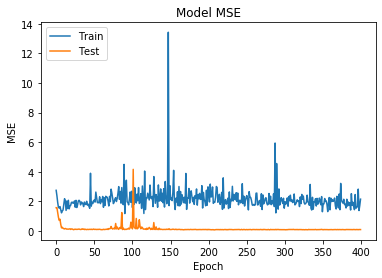

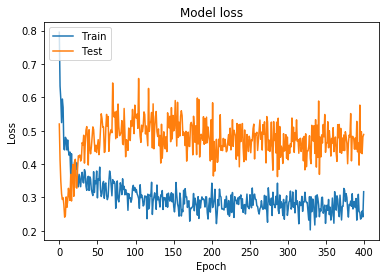

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = trainer.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

In [7]:
model = trainer.model
pred = None
label = None
pred_ = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
prediction = []
for x,y in train:
    for i in range(batch_size):
        if y[i,:,:,:].max() > 0:
            pred = model(np.array([x[i,:,:,:]]))
            prediction.append(pred)
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
    if len(label) >= pred_:
        break
        


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:108: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


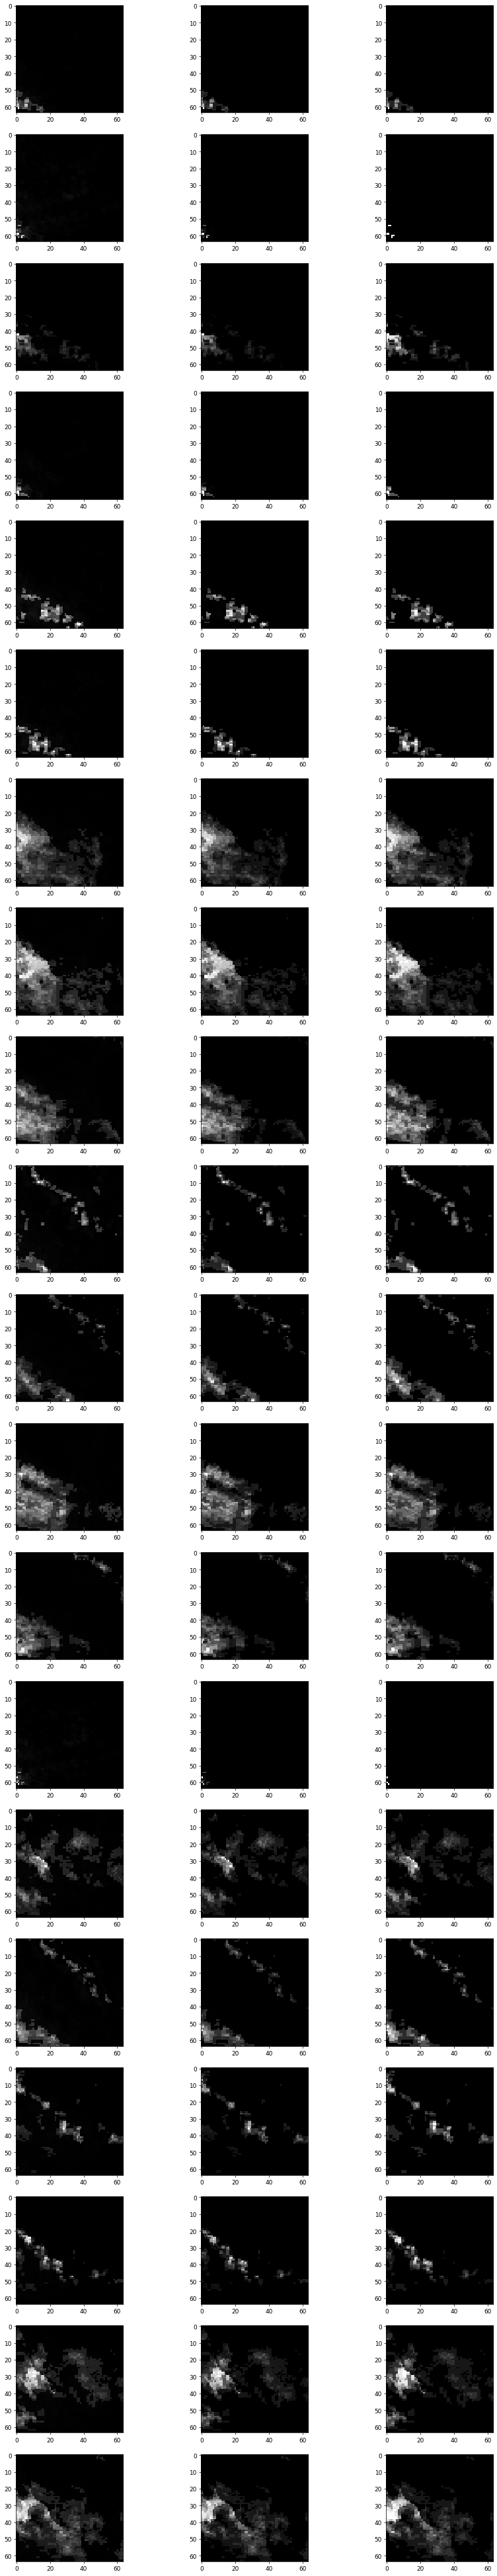

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
fig, axes = plt.subplots(20, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")

In [9]:
def map_Dist_To_Rain(prediction,label):
    
    x,y,t      = prediction[0][0,:,:,:].shape
    rain_true  = np.zeros((x,y,t))
    rain_false = rain_true.copy()
    
    
    
    ones = np.ones((x,y))
    zeros = np.zeros((x,y,t))
    value_map = np.array([ones * i/255 for i in range(256)])
    value_map = value_map.transpose(1,2,0)
    for i,pred in enumerate(prediction):
        ones = np.ones((x,y,t)) * 3/255
        #print((np.array(pred.prob(ones))).max(axis=-1) )
        probs = np.array(pred.prob(value_map))
        print(label[i].max())
        max_probs = probs.argmax(axis=-1)
        #print(probs[0,1,1,:].argmax())

        #print(probs.argmax(axis=-1))
        #print(probs.max(axis=-1))
        for j in range(64):
            for k in range(64):
                at = np.argmax(probs[0,k,j,:])
                if at > 0:
                #at = probs[0,k,j,:] .sum()
                    print("AATT",at)
        #    print(j,"min:",probs[:,:,:,j].min(),"max:",probs[:,:,:,j].max())
        #print(probs.shape)
        #print(probs)
        #print(pred.prob(0.0))
        print(np.array(pred.prob(label[i].max())).max() )
        print(np.array(pred.prob(label[i].max())).min() )
        if label[i].max() == 0:
            continue

        print(pred)
        s = (1-pred.cdf(zeros))
        
        #print(np.array(s).max(),np.array(probs.mean()).max(),label[i].max())
        
        plt.imshow(max_probs[0,:,:],cmap="gray")
        plt.show()
        plt.imshow(s[0,:,:,0],cmap="gray")
        plt.show()
        plt.imshow(label[i][:,:,0],cmap="gray")
        plt.show()
        break
    

#map_Dist_To_Rain(prediction,label)
print(prediction[0])

tfp.distributions.Independent("model_DistributionLayer_Independentmodel_DistributionLayer_NegativeBinomial", batch_shape=[1, 64, 64, 1], event_shape=[], dtype=float32)


7
4.326467


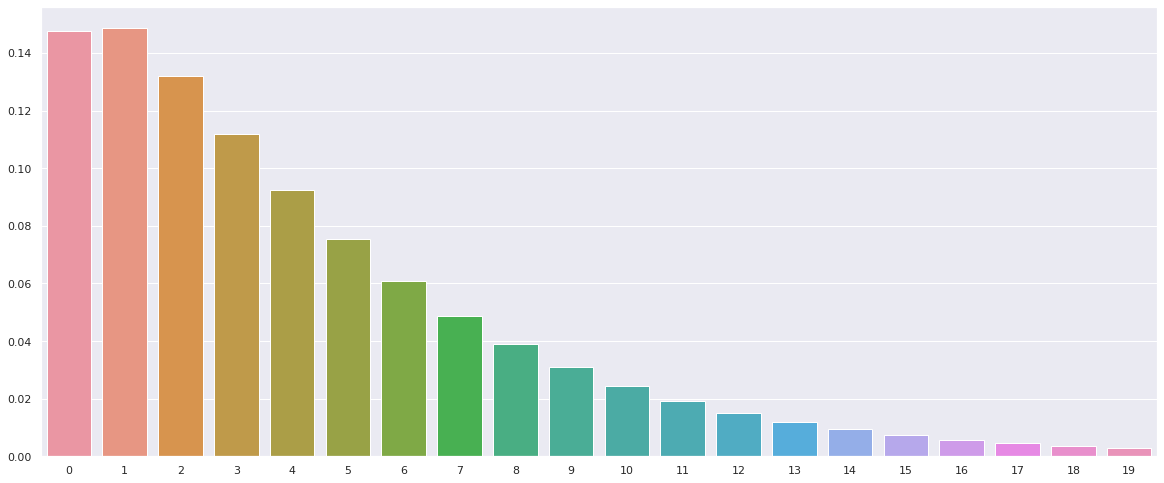

In [11]:
a = np.arange(20)
print(label[0].max())
idx = np.where(label[0] == label[0].max() )
pred = prediction[0]
for i in range(20):
    a = np.ones((64,64,1)) * i
    #print(i,np.array(pred.prob(a)).max() )
#print(np.array(pred.mean())[33,28])
y = []
x = []
for i in range(20):
    x.append(i)
    #print(i,np.array(pred.prob(i))[0,33,28,:] )
    y.append(np.array(pred.prob(i))[0,idx[0],idx[1],0][0])
print(np.array(pred.mean())[0,idx[0],idx[1],0][0])

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.barplot(x,y)